<a href="https://colab.research.google.com/github/vblagoje/notebooks/blob/main/haystack2x-demos/ReAct_Haystack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ReAct Pipeline with Haystack

This notebook implements a ReAct (https://arxiv.org/abs/2210.03629) pipeline using Haystack components. The pipeline:

1. Uses OpenAI's GPT-4 model for generating thoughts and actions
2. Utilizes SerperDev for web searches
3. Processes questions iteratively, generating thoughts, actions, and observations
4. Cycles through Thought, Action, Observation steps until a final answer is reached

Key components:
- OpenAIChatGenerator for thought/observation generation
- SerperDevWebSearch for web searches
- ConditionalRouter for action routing
- Custom adapters and joiners for prompt management and ReAct loop

At the bottom of the notebook, the pipeline is demonstrated by answering two sample questions, showcasing its ability to reason, search for information, and provide answers based on the gathered data.

# Table of Contents

1. [Setup and Imports](#scrollTo=OjWc7mH0UCXp)
2. [Setup API keys](#scrollTo=MJf9GKJOUCXq)
3. [Helper functions](#scrollTo=6T-bMr9nUCXq)
4. [Prompt templates](#scrollTo=DQKnV1okUCXq)
5. [Define ReAct pipeline using Haystack components](#scrollTo=QHS_28eIUCXr)
6. [Visualize the pipeline](#scrollTo=2YJONdACUCXs)
7. [Run the ReAct pipeline](#scrollTo=_98BNs44UCXs)

In [1]:
# tmp until https://community.openai.com/t/error-with-openai-1-56-0-client-init-got-an-unexpected-keyword-argument-proxies/1040332/2 is fixed
!pip install openai==1.55.3 httpx==0.27.2 --force-reinstall --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.0/172.0 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 389.6/389.6 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.4/70.4 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.0/345.0 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 457.0/457.0 kB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 57.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.3/167.3 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3

In [2]:
!pip install -q haystack-ai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 391.4/391.4 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.8/54.8 kB 1.2 MB/s eta 0:00:00


## Setup and Imports

We only need a handful of standard Haystack components to implement ReAct.


In [3]:
import os
from getpass import getpass
import re

from typing import List
from haystack.dataclasses import ChatMessage
from haystack.components.builders import ChatPromptBuilder
from haystack.components.converters import OutputAdapter
from haystack.components.routers import ConditionalRouter
from haystack.components.joiners import BranchJoiner
from haystack.components.generators.chat import OpenAIChatGenerator
from haystack.components.websearch import SerperDevWebSearch
from haystack import Pipeline
from haystack.utils import Secret

## Setup API keys

We'll use OpenAI LLMs and SerperDev for search.

In [4]:
os.environ["OPENAI_API_KEY"] = getpass("OpenAI API key: ")
os.environ["SERPERDEV_API_KEY"] = getpass("Serperdev API key: ")

OpenAI API key: ··········
Serperdev API key: ··········


## Helper functions

The `find_last_action` and `concat_prompt`are simple helper functions used to parse the output of the OpenAI LLM and extract the last action and concatenate the prompt.

In [5]:
def find_last_action(messages: List[ChatMessage]):
    prompt: str = messages[-1].content
    lines = prompt.strip().split('\n')
    for line in reversed(lines):
        pattern = r'Action\s*\d*:\s*(\w+)\[(.*?)\]'

        match = re.search(pattern, line)
        if match:
            action_name = match.group(1)
            parameter = match.group(2)
            return [action_name, parameter]
    return [None, None]


def concat_prompt(last_message: ChatMessage, current_prompt: List[ChatMessage], append: str, verbose: bool = True):
    print(last_message.content + append)
    return [ChatMessage.from_user(current_prompt[-1].content + last_message.content + append)]

## Prompt templates

We'll use the following templates for the prompts. The first is for the web search, and the second is for the ReAct loop.

In [6]:
search_message_template = """
Given these web search results:

{% for doc in documents %}
    {{ doc.content }}
{% endfor %}

Be as brief as possible, max one sentence.
Answer the question: {{search_query}}
"""
react_message_template = """
Solve a question answering task with interleaving Thought, Action, Observation steps.

Thought reasons about the current situation

Action can be:
google_search - Searches Google for the exact concept/entity (given in square brackets) and returns the results for you to use
finish - Returns the final answer (given in square brackets) and finishes the task

Observation summarizes the Action outcome and helps in formulating the next
Thought in Thought, Action, Observation interleaving triplet of steps.

After each Observation, provide the next Thought and next Action.
Don't execute multiple steps even though you know the answer.
Only generate Thought and Action, never Observation, you'll get Observation from Action.
Follow the pattern in the examples below.

Examples:
###########################
Question: Which magazine was started first Arthur’s Magazine or First for Women?
Thought: I need to search Arthur’s Magazine and First for Women, and find which was started
first.
Action: google_search[When was 'Arthur’s Magazine' started?]
Observation: Arthur’s Magazine was an American literary periodical ˘
published in Philadelphia and founded in 1844. Edited by Timothy Shay Arthur, it featured work by
Edgar A. Poe, J.H. Ingraham, Sarah Josepha Hale, Thomas G. Spear, and others. In May 1846
it was merged into Godey’s Lady’s Book.
Thought: Arthur’s Magazine was started in 1844. I need to search First for Women founding date next
Action: google_search[When was 'First for Women' magazine started?]
Observation: First for Women is a woman’s magazine published by Bauer Media Group in the
USA. The magazine was started in 1989. It is based in Englewood Cliffs, New Jersey. In 2011
the circulation of the magazine was 1,310,696 copies.
Thought: First for Women was started in 1989. 1844 (Arthur’s Magazine) ¡ 1989 (First for
Women), so Arthur’s Magazine was started first.
Action: finish[Arthur’s Magazine]
############################
Question:	Which documentary is about Finnish rock groups, Adam Clayton Powell or The Saimaa Gesture?
Thought: I need to search Adam Clayton Powell and The Saimaa Gesture, and find which documentary is about Finnish rock groups.
Action: google_search[Adam Clayton Powell (film)]
Observation: Adam Clayton Powell is a 1989 American documentary film directed by Richard Kilberg. The film is about the rise and fall of influential African-American politician Adam Clayton Powell Jr.[3][4] It was later aired as part of the PBS series The American Experience.
Thought:	Adam Clayton Powell (film) is a documentary about an African-American politician, not Finnish rock groups. So the documentary about Finnish rock groups must instead be The Saimaa Gesture.
Action: finish[The Saimaa Gesture]
############################

Let's start, the question is: {{query}}
"""

routes = [
    {
        "condition": "{{'search' in tool_id_and_param[0]}}",
        "output": "{{tool_id_and_param[1]}}",
        "output_name": "search",
        "output_type": str,
    },
    {
        "condition": "{{'finish' in tool_id_and_param[0]}}",
        "output": "{{tool_id_and_param[1]}}",
        "output_name": "finish",
        "output_type": str,
    }
]

## Define ReAct pipeline using Haystack components

In [7]:
# define ReAct pipeline
pipeline = Pipeline()
pipeline.add_component("react_loop_input", BranchJoiner(List[ChatMessage]))
pipeline.add_component("react_prompt_builder", ChatPromptBuilder(variables=["query"]))
pipeline.add_component("thought_action_generator", OpenAIChatGenerator(model="gpt-4o"))

# tools
pipeline.add_component("action_extractor", OutputAdapter("{{messages | find_action}}",
                                                       output_type=List[str],
                                                       custom_filters={"find_action": find_last_action},
                                                       unsafe=True))

pipeline.add_component("prompt_concatenator_after_action",
                       OutputAdapter("{{replies[-1] | concat_prompt(current_prompt,'')}}",
                                     output_type=List[ChatMessage],
                                     custom_filters={"concat_prompt": concat_prompt},
                                     unsafe=True))

pipeline.add_component("action_router", ConditionalRouter(routes, unsafe=True))
pipeline.add_component("search_tool",
                       SerperDevWebSearch(api_key=Secret.from_env_var("SERPERDEV_API_KEY")))
pipeline.add_component("search_prompt_builder", ChatPromptBuilder(variables=["documents", "search_query"]))
pipeline.add_component("observation_generator", OpenAIChatGenerator(model="gpt-4o"))
pipeline.add_component("final_output_formatter", OutputAdapter("{{final_answer | format_final_answer}}",
                                                      output_type=str,
                                                      custom_filters={"format_final_answer": lambda x: x},
                                                      unsafe=True))

pipeline.add_component("observation_adapter", OutputAdapter("{{search_replies | format_observation}}",
                                                              output_type=List[ChatMessage],
                                                              custom_filters={"format_observation": lambda x: [
                                                                  ChatMessage.from_assistant(
                                                                      "Observation: " + x[-1].content + "\n")]},
                                                              unsafe=True))

pipeline.add_component("prompt_concatenator_after_observation",
                       OutputAdapter("{{replies[-1] | concat_prompt(current_prompt, 'Thought:')}}",
                                     output_type=List[ChatMessage],
                                     custom_filters={"concat_prompt": concat_prompt},
                                     unsafe=True))

# main
pipeline.connect("react_loop_input", "react_prompt_builder.template")
pipeline.connect("react_prompt_builder.prompt", "thought_action_generator.messages")
pipeline.connect("thought_action_generator.replies", "prompt_concatenator_after_action.replies")

# tools
pipeline.connect("react_prompt_builder.prompt", "prompt_concatenator_after_action.current_prompt")
pipeline.connect("prompt_concatenator_after_action", "action_extractor.messages")

pipeline.connect("action_extractor", "action_router")
pipeline.connect("action_router.search", "search_tool.query")
pipeline.connect("search_tool.documents", "search_prompt_builder.documents")
pipeline.connect("action_router.search", "search_prompt_builder.search_query")
pipeline.connect("search_prompt_builder.prompt", "observation_generator.messages")
pipeline.connect("action_router.finish", "final_output_formatter")

pipeline.connect("observation_generator.replies", "observation_adapter.search_replies")
pipeline.connect("observation_adapter", "prompt_concatenator_after_observation.replies")
pipeline.connect("prompt_concatenator_after_action", "prompt_concatenator_after_observation.current_prompt")

pipeline.connect("prompt_concatenator_after_observation", "react_loop_input")

/usr/local/lib/python3.10/dist-packages/haystack/components/converters/output_adapter.py:79: UserWarning: Unsafe mode is enabled. This allows execution of arbitrary code in the Jinja template. Use this only if you trust the source of the template.
  warn(msg)
/usr/local/lib/python3.10/dist-packages/haystack/components/routers/conditional_router.py:195: UserWarning: Unsafe mode is enabled. This allows execution of arbitrary code in the Jinja template. Use this only if you trust the source of the template.
  warn(msg)


🚅 Components
  - react_loop_input: BranchJoiner
  - react_prompt_builder: ChatPromptBuilder
  - thought_action_generator: OpenAIChatGenerator
  - action_extractor: OutputAdapter
  - prompt_concatenator_after_action: OutputAdapter
  - action_router: ConditionalRouter
  - search_tool: SerperDevWebSearch
  - search_prompt_builder: ChatPromptBuilder
  - observation_generator: OpenAIChatGenerator
  - final_output_formatter: OutputAdapter
  - observation_adapter: OutputAdapter
  - prompt_concatenator_after_observation: OutputAdapter
🛤️ Connections
  - react_loop_input.value -> react_prompt_builder.template (List[ChatMessage])
  - react_prompt_builder.prompt -> thought_action_generator.messages (List[ChatMessage])
  - react_prompt_builder.prompt -> prompt_concatenator_after_action.current_prompt (List[ChatMessage])
  - thought_action_generator.replies -> prompt_concatenator_after_action.replies (List[ChatMessage])
  - action_extractor.output -> action_router.tool_id_and_param (List[str])
  - 

## Visualize the pipeline

Notice the cycle in the pipeline at the bottom. If we didn't reach the finish action, the pipeline would continue to loop.

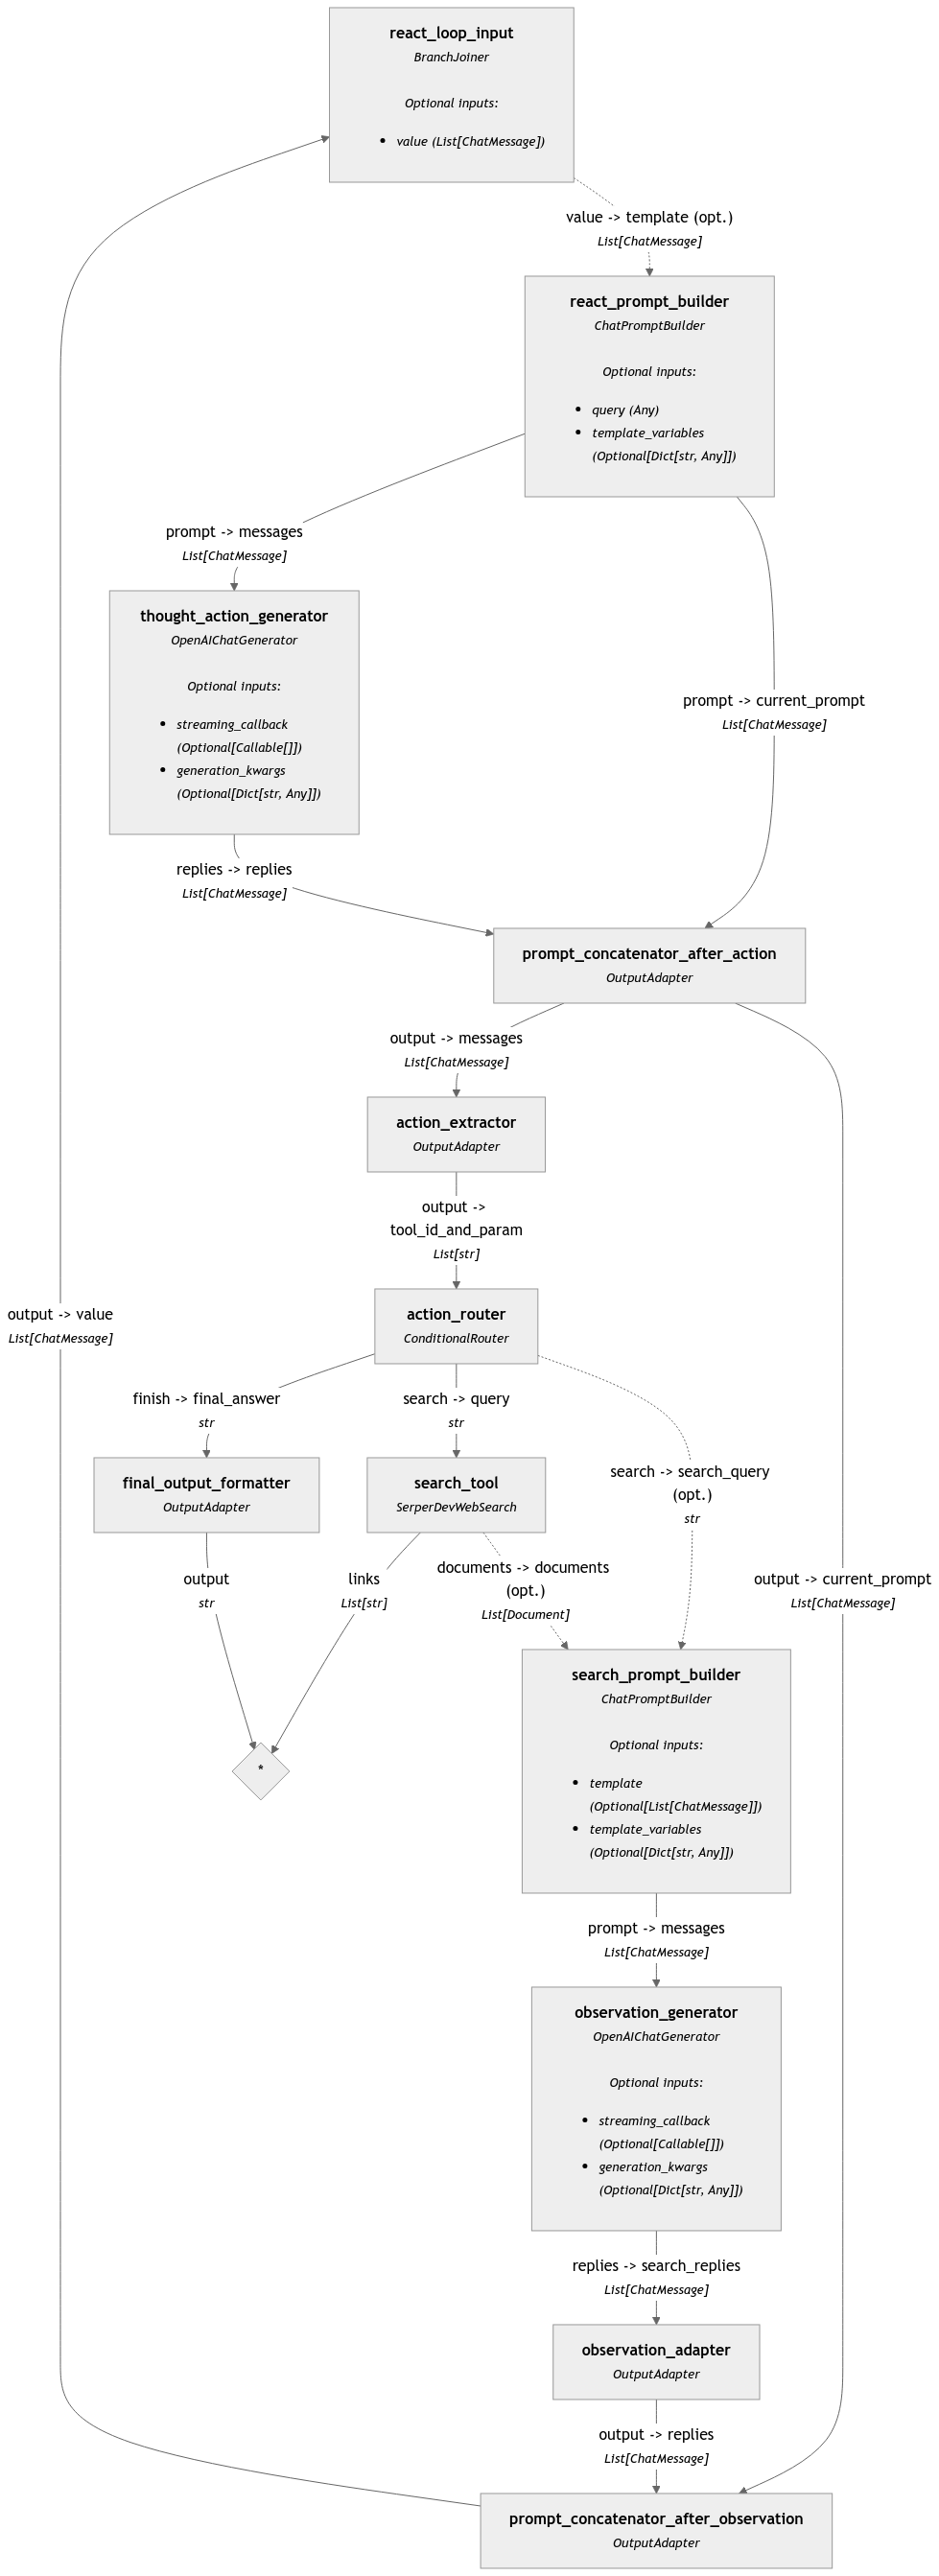

In [8]:
pipeline.show()

## Run the ReAct pipeline


In [9]:
questions = ["What is the elevation range for the area that the eastern sector of the Colorado orogeny extends into?",
             "Which tower is taller: Tower of Pisa or Eiffel Tower?"]

for question in questions:
  print("Q: " + question)
  res = pipeline.run(data={"react_loop_input": {"value": [ChatMessage.from_user(react_message_template)]},
                          "react_prompt_builder": {"template_variables": {"query": question}},
                          "search_prompt_builder": {"template": [ChatMessage.from_user(search_message_template)]}})

  print("Final Answer: " + res["final_output_formatter"]["output"])
  print("=" * 100)

Q: What is the elevation range for the area that the eastern sector of the Colorado orogeny extends into?
Thought: I need to search for information related to the eastern sector of the Colorado orogeny and the elevation range of the area it extends into. 

Action: google_search[Eastern sector of the Colorado orogeny elevation range]
Observation: The elevation range of the eastern sector of the Colorado orogeny is approximately 1,800 to 7,000 feet (550 to 2,130 meters).
Thought:
The elevation range for the eastern sector of the Colorado orogeny is approximately 1,800 to 7,000 feet. 

Action: finish[1,800 to 7,000 feet (550 to 2,130 meters)]
Final Answer: 1,800 to 7,000 feet (550 to 2,130 meters)
Q: Which tower is taller: Tower of Pisa or Eiffel Tower?
Thought: I need to search the height details of both the Tower of Pisa and the Eiffel Tower to determine which one is taller.

Action: google_search[Height of Tower of Pisa]
Observation: The Tower of Pisa is 56.67 meters (185.93 feet) tall